In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm

In [2]:
DATADIR = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\train"
CATEGORIES = ['0', '1','2','3','4','5','6','7','8','9']
IMG_SIZE=50

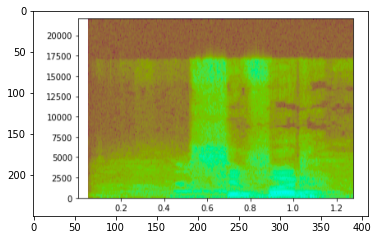

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [4]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

In [5]:
print(len(training_data))

930


In [6]:
lenofimage = len(training_data)

In [7]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

In [8]:
X.shape

(930, 7500)

In [9]:
X = X/255.0

In [10]:
X[1]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
y=np.array(y)

In [12]:
y.shape

(930,)

In [13]:
SEED = 42
from sklearn.model_selection import train_test_split
import random
random.seed(SEED)
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(X,y, test_size=0.1, random_state=SEED)

In [14]:
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
import warnings
warnings.filterwarnings("ignore")
from keras.optimizers import SGD

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

In [16]:
testY

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1,

In [17]:
#Initialising ANN
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense

model = Sequential()   # input layer 7500 as there are 32x32x3=3072 pixels in a flattened input image
model.add(Dense(1024, input_shape=(7500,), activation="relu"))# first hidden layer has 1024 nodes
model.add(Dense(512, activation="relu"))                         # second hidden layer has 512 nodes
model.add(Dense(len(CATEGORIES), activation="softmax"))            # output layer with number of possible class labels

In [18]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.01)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                   specificity,conditional_average_metric ,sensitivity,F1_Score,'accuracy']

In [19]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 60
 
# compile the model using SGD as our optimizer and categorical cross-entropy loss
# (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)   # Stochastic Gradient Descent (SGD) optimizer
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics)

[INFO] training network...


In [20]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

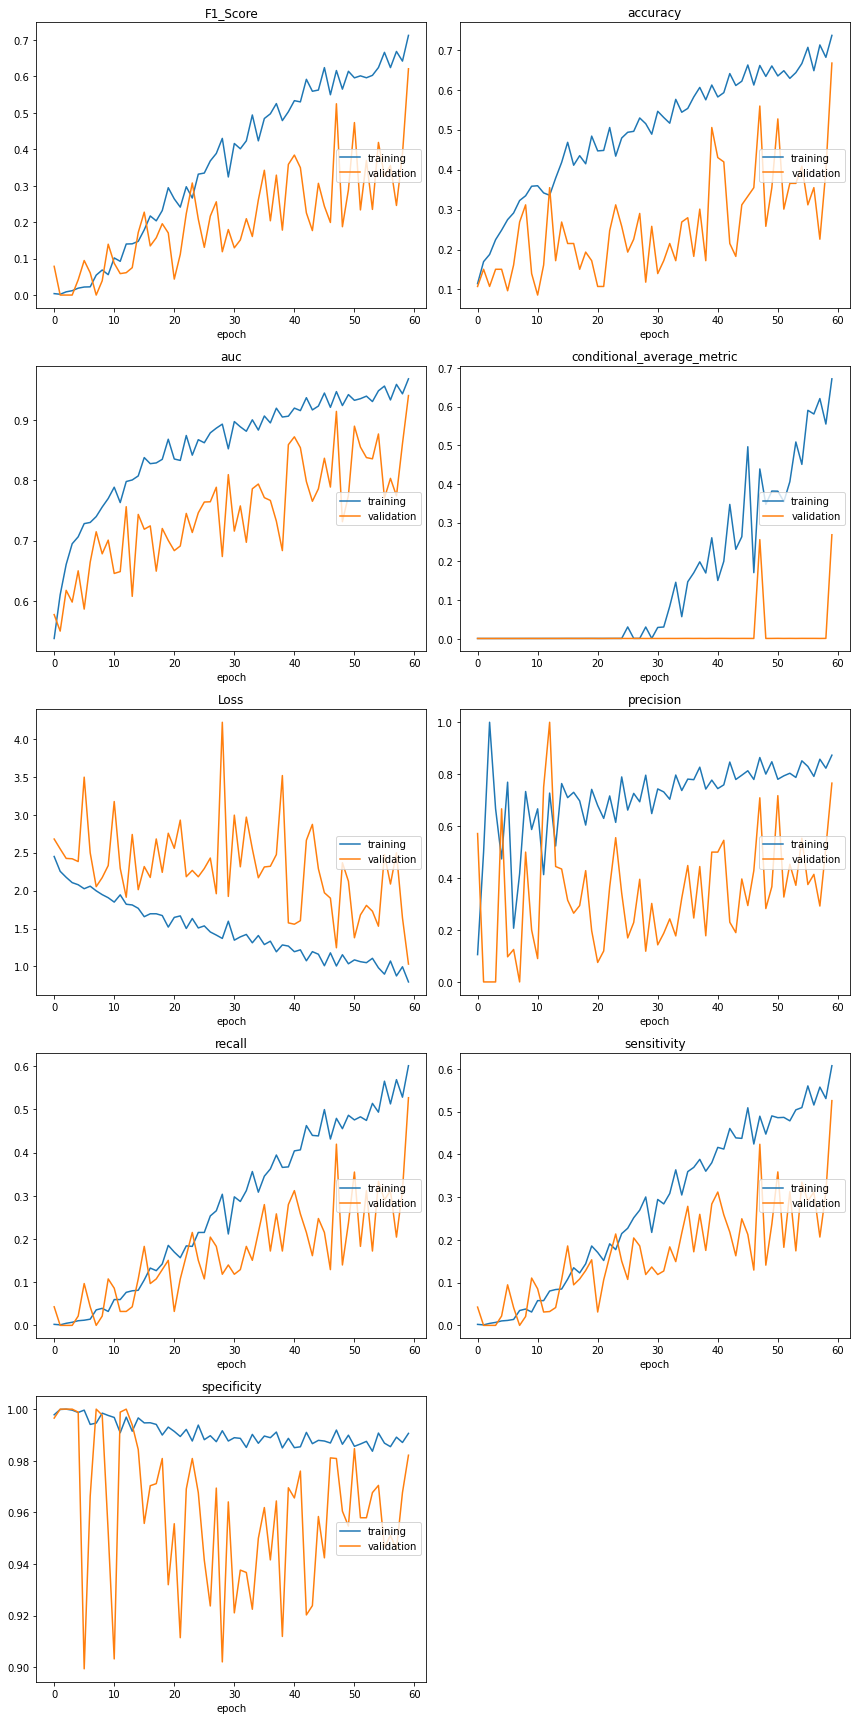

F1_Score
	training         	 (min:    0.002, max:    0.713, cur:    0.713)
	validation       	 (min:    0.000, max:    0.621, cur:    0.621)
accuracy
	training         	 (min:    0.115, max:    0.736, cur:    0.736)
	validation       	 (min:    0.086, max:    0.667, cur:    0.667)
auc
	training         	 (min:    0.538, max:    0.968, cur:    0.968)
	validation       	 (min:    0.550, max:    0.940, cur:    0.940)
conditional_average_metric
	training         	 (min:    0.001, max:    0.672, cur:    0.672)
	validation       	 (min:    0.001, max:    0.269, cur:    0.269)
Loss
	training         	 (min:    0.795, max:    2.450, cur:    0.795)
	validation       	 (min:    1.031, max:    4.220, cur:    1.031)
precision
	training         	 (min:    0.105, max:    1.000, cur:    0.873)
	validation       	 (min:    0.000, max:    1.000, cur:    0.766)
recall
	training         	 (min:    0.001, max:    0.601, cur:    0.601)
	validation       	 (min:    0.000, max:    0.527, cur:    0.527)
sensi

In [21]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32,callbacks = [plot_loss_1])
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

In [22]:
y2 = model.predict(testX)
print(y2)

3/3 [==============================] - 1s 17ms/step
[[9.13289085e-04 1.49079757e-02 9.60023899e-05 9.24916894e-05
  3.62396822e-05 9.88316373e-04 2.12277542e-03 9.72959220e-01
  6.39812183e-03 1.48571422e-03]
 [1.76047673e-04 1.65928472e-02 1.05191721e-02 2.77843438e-02
  3.42252068e-02 6.95080757e-02 5.84429979e-01 3.76388691e-02
  3.32559086e-02 1.85869545e-01]
 [3.42721164e-01 1.85942259e-02 7.26738526e-03 7.41944741e-03
  5.68434922e-03 1.31049389e-02 1.86581295e-02 5.73325574e-01
  6.48306916e-03 6.74167881e-03]
 [3.42897052e-04 6.67741522e-02 2.80950367e-01 8.39289948e-02
  1.38648017e-03 1.42230526e-01 1.06532208e-03 6.33553267e-02
  6.14173412e-02 2.98548549e-01]
 [2.20455855e-04 9.72401500e-01 2.24251510e-03 2.01520845e-04
  2.56753759e-04 5.55028068e-03 1.38329656e-03 1.13675930e-02
  3.32151749e-03 3.05450661e-03]
 [8.29804037e-03 7.63561726e-01 1.44582093e-02 7.81443939e-02
  1.30602974e-03 4.91115339e-02 4.32088859e-02 1.87664665e-02
  3.87839042e-03 1.92663427e-02]
 [3.40

In [23]:
# evaluate the network
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=CATEGORIES))

[INFO] evaluating network...
3/3 [==============================] - 1s 47ms/step
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.50      1.00      0.67        11
           2       1.00      0.55      0.71        11
           3       0.40      0.25      0.31         8
           4       0.88      0.70      0.78        10
           5       0.78      0.78      0.78         9
           6       0.83      0.50      0.62        10
           7       0.45      1.00      0.62         9
           8       1.00      0.50      0.67         4
           9       0.75      0.55      0.63        11

    accuracy                           0.67        93
   macro avg       0.76      0.65      0.66        93
weighted avg       0.75      0.67      0.67        93



In [24]:
y_pred=np.argmax(y2, axis=1)
y_test=np.argmax(testY, axis=1)

<AxesSubplot:>

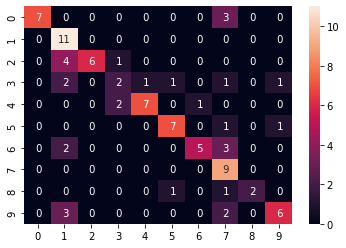

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')